# Part E - Prediction Pipeline

Pipeline to extract all "Hello World" phrases from a given image and return predictions

### Approach:
    1) Step 1: Grayscaling and thresholding on the original image
        - To make non-text region to 255, otherwise 0
        - Helps in identifying clear contours
    
    2) Step 2: Identifying bounding boxes of the text "Hello, World!"
        - Get all horizontal text regions by iterating from top to bottom and looking for non zeros lines
        
        - For all horizontal text region split all text ("Hello World!") occuraces
        
            - Clip empty area on left and right on the horizontal box
            
            - Dilate the region to merge the characters in a phrase together
                - Kernel size is estimated dynamically based on average width of each word in the phrase
                
            - Contour detection and getting bounding box
            
            
    3) Step 3: Predict for each bounding box 
    

In [1]:
import cv2

import pickle
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

from keras.applications import resnet50
from keras.preprocessing import image

### Load prediction image and trained model

In [2]:
# Load best model saved as .pkl
with open('models/xgb_augumented_weights.pkl', 'rb') as load_filepath:
    prediction_model = pickle.load(load_filepath)

### Step 1: Grayscaling and thresholding on the original image

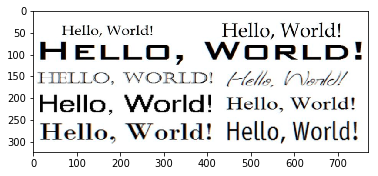

In [3]:
# Load image to get prediction from
img = cv2.imread("prediction.png")

imgplot = plt.imshow(img)
plt.show()

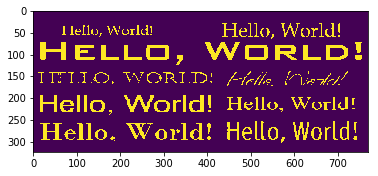

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 

imgplot = plt.imshow(otsu_thresh)
plt.show()

### Step 2: Identifying bounding boxes of the text "Hello, World!"

{'boundingBox': {'x': 424, 'y': 27, 'width': 281, 'height': 39}}


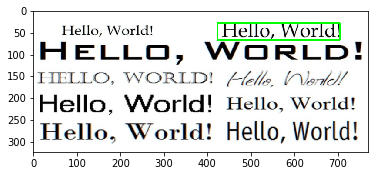

{'boundingBox': {'x': 67, 'y': 27, 'width': 218, 'height': 39}}


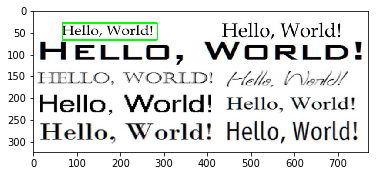

{'boundingBox': {'x': 17, 'y': 71, 'width': 738, 'height': 52}}


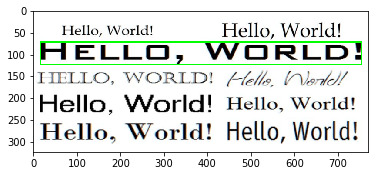

{'boundingBox': {'x': 430, 'y': 138, 'width': 292, 'height': 36}}


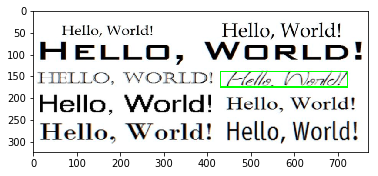

{'boundingBox': {'x': 11, 'y': 138, 'width': 418, 'height': 36}}


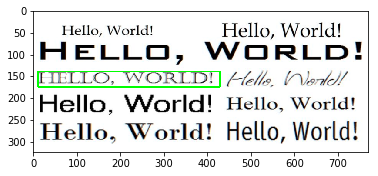

{'boundingBox': {'x': 431, 'y': 192, 'width': 307, 'height': 46}}


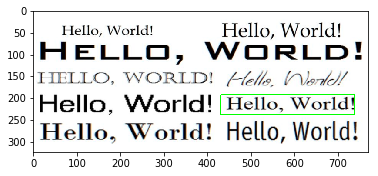

{'boundingBox': {'x': 15, 'y': 192, 'width': 409, 'height': 46}}


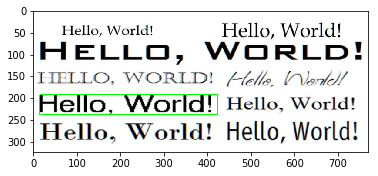

{'boundingBox': {'x': 433, 'y': 252, 'width': 311, 'height': 52}}


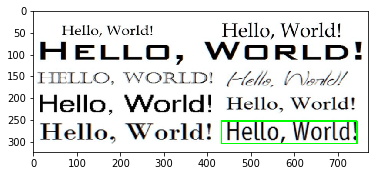

{'boundingBox': {'x': 17, 'y': 252, 'width': 406, 'height': 52}}


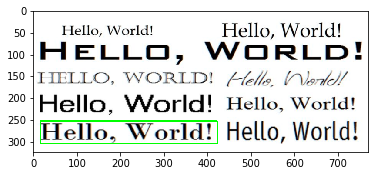

In [5]:
output = {"detectedFonts": []}

x_coordinates = []
y_coordinates = []


# Get all horizontal text regions in the image

cropped_image_lines = []
last_line_zeros = True

for i in range(len(otsu_thresh)):
    
    line_zeros = True
    for j in range(len(otsu_thresh[i])):
        
        if otsu_thresh[i][j] == 255:
            line_zeros = False
            break
    
    if last_line_zeros != line_zeros:
        y_coordinates.append(i)

    last_line_zeros = line_zeros
    

# For all horizontal text regions identify location of phrases
    
for i in range(0, len(y_coordinates), 2):
    
    x1 = y_coordinates[i]
    x2 = y_coordinates[i + 1]
    
    # Get min and max x coordinates to remove white region at start and end
    all_whites = []
    for j in range(x1, x2):
        
        for k in range(0, len(otsu_thresh[0])):
            
            if otsu_thresh[j][k] == 255:
                all_whites.append(k)
                
    y1 = min(all_whites)
    y2 = max(all_whites)
    
    x_coordinates.append(y1)
    x_coordinates.append(y2)
    
    
    # Crop horizontal region
    im_cropped = img[x1: x2, y1: y2]
    cropped_image_lines.append(im_cropped)
    
    gray = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2GRAY)
    ret, thresh_cropped = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 
    
    # Estimation of index of dilution
    _, contours, hierarchy = cv2.findContours(thresh_cropped, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_NONE)
        
    all_widths = []
    for cnt in contours: 
        x, y, w, h = cv2.boundingRect(cnt)
        all_widths.append(w)
        
    average_width = int(np.array(all_widths).mean() + np.array(all_widths).mean() / 2)
    
    # Dilute image to merge characters
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (average_width, average_width)) 
    dilation = cv2.dilate(thresh_cropped, rect_kernel, iterations = 1) 
        
    # Find contours for the whole phrase
    _, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_NONE)
    
    for cnt in contours: 
        x, y, w, h = cv2.boundingRect(cnt)    
        rect = cv2.rectangle(img.copy(), (y1 + x, x1 + y), (y1 + x + w, x1 + y + h), (0, 255, 0), 2)
        
        box = {
            "boundingBox": {
                "x": y1 + x,
                "y": x1 + y,
                "width": w,
                "height": h
            }
        }
        output["detectedFonts"].append(box)
        
        print (box)
        imgplot = plt.imshow(rect)
        plt.show()

### Step 3: Predict for each bounding box 

In [6]:
import os
os.makedirs('data/prediction_preprocessed_images',  exist_ok=True)

image_vectors = []
def get_prediction_from_image(im, list_bounding_boxes):
    
    # Preprocess image
    for i in range(len(list_bounding_boxes)):
        box = list_bounding_boxes[i]['boundingBox']
        cropped_im = im[box['y']:box['y'] + box['height'], box['x']:box['x'] + box['width']] 
        
        imgplot = plt.imshow(cropped_im)
        plt.show()
        
        resized_cropped_im = cv2.resize(cropped_im, (224, 224), interpolation=cv2.INTER_AREA)
        
        cv2.imwrite('data/prediction_preprocessed_images/box{}.png'.format(i), resized_cropped_im)
        
        with Image.open('data/prediction_preprocessed_images/box{}.png'.format(i)) as image_vector:
            image_vectors.append(image_vector.copy())
    

    # Preprocessing for Resnet50
    image_arrays = [image.img_to_array(vector) for vector in image_vectors]
    processed_arrays = resnet50.preprocess_input(np.array(image_arrays))

    # Load pretrained model (Max pooling is used as the original features are 7 x 7 x 2048)
    model = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='max')
    features = model.predict(processed_arrays)

    # Flatten features
    features = [x.reshape(1, 2048)[0] for x in features]
    
    scores = prediction_model.predict_proba(features)
    predictions = list(pd.DataFrame(scores, columns=prediction_model.classes_).idxmax(axis=1))
    prediction_scores = list(pd.DataFrame(scores, columns=prediction_model.classes_).max(axis=1))
    
    print (predictions)
    print (prediction_scores)
    
    return predictions, prediction_scores

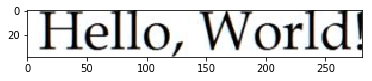

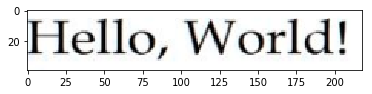

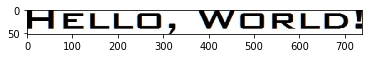

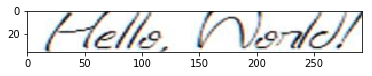

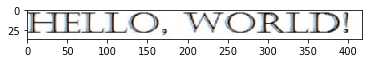

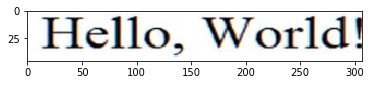

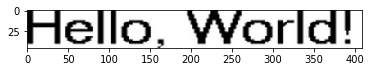

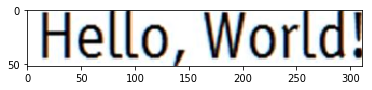

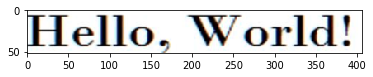

['PTSerif', 'PTSerif', 'Roboto', 'DancingScript', 'PTSerif', 'PTSerif', 'Arimo', 'Arimo', 'PTSerif']
[0.5548796, 0.8720485, 0.4246499, 0.77434736, 0.6131219, 0.6613661, 0.35196823, 0.40209395, 0.83995265]


In [7]:
predictions, prediction_scores = get_prediction_from_image(img, output['detectedFonts'])

In [8]:
for i in range(len(output['detectedFonts'])):
    output['detectedFonts'][i]['font'] = predictions[i]
    output['detectedFonts'][i]['confidence'] = prediction_scores[i]

In [9]:
import pprint

pp = pprint.PrettyPrinter(indent=2, width=10)
pp.pprint(output)

{ 'detectedFonts': [ { 'boundingBox': { 'height': 39,
                                        'width': 281,
                                        'x': 424,
                                        'y': 27},
                       'confidence': 0.5548796,
                       'font': 'PTSerif'},
                     { 'boundingBox': { 'height': 39,
                                        'width': 218,
                                        'x': 67,
                                        'y': 27},
                       'confidence': 0.8720485,
                       'font': 'PTSerif'},
                     { 'boundingBox': { 'height': 52,
                                        'width': 738,
                                        'x': 17,
                                        'y': 71},
                       'confidence': 0.4246499,
                       'font': 'Roboto'},
                     { 'boundingBox': { 'height': 36,
                                        'width': 292